<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP2_1_SkimLit%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2.1: SkimLit+

Esta é a continuidade do projeto SkimLit, segundo milestone project do curso TensorFlow Developer Certificate in 2023: Zero to Mastery. https://www.udemy.com/share/104ssS3@m--2vC9jNX6kIapUf0IUOOxnuj8_1SisbHiZTsJDQ5z2toWaLfaenc4bvZ4i2Yd5/

# Importações

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import Bidirectional, Concatenate, Dense, Dropout, Embedding, Input, LSTM, TextVectorization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Configurações, constantes e variáveis globais

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

COR = '#007f66'

DIRETORIO = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

LIMITE_DICIONARIO = 68000
LIMITE_CARACTERES = 80

LIMITE_INCORPORADOR = 300
LIMITE_INCORPORADOR_CARACTERES = 25
LIMITE_VETOR_TEXTO = 100

LOTE_TAMANHO = 32

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'softmax'

SUAVIZACAO = 0.2
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 3

avaliacoes = [None] * 6

# Funções

In [3]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-02-01 17:06:54--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7753 (7.6K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-02-01 17:06:54 (59.8 MB/s) - ‘funcoes.py’ saved [7753/7753]



In [4]:
from funcoes import avaliar_modelo, grafico_historico_por_iteracao, preprocessar_texto

# Dados

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.17 MiB/s, done.


In [6]:
df_treino    = pd.DataFrame(preprocessar_texto(f'{DIRETORIO}/train.txt'))
df_validacao = pd.DataFrame(preprocessar_texto(f'{DIRETORIO}/dev.txt'))

codificador_onehot = OneHotEncoder(sparse=False)

rotulos_onehot_treino    = codificador_onehot.fit_transform(df_treino['classe'].to_numpy().reshape(-1, 1))
rotulos_onehot_validacao = codificador_onehot.transform(df_validacao['classe'].to_numpy().reshape(-1, 1))

codificador_int = LabelEncoder()

rotulos_int_treino    = codificador_int.fit_transform(df_treino['classe'].to_numpy())
rotulos_int_validacao = codificador_int.transform(df_validacao['classe'].to_numpy())

classes = codificador_int.classes_

palavras_por_texto_98   = int(np.percentile([len(texto.split()) for texto in df_treino['texto']], 98))
caracteres_por_texto_98 = int(np.percentile([len(texto) for texto in df_treino['texto']], 98))

lista_caracteres_treino    = [" ".join(list(texto)) for texto in df_treino['texto']]
lista_caracteres_validacao = [" ".join(list(texto)) for texto in df_validacao['texto']]

numero_linha_98 = int(np.percentile(df_treino['numero'], 98))

linhas_numero_onehot_treino    = tf.one_hot(df_treino['numero'], depth=numero_linha_98)
linhas_numero_onehot_validacao = tf.one_hot(df_validacao['numero'], depth=numero_linha_98)

total_linhas_98 = int(np.percentile(df_treino['total'], 98))

linhas_total_onehot_treino    = tf.one_hot(df_treino['total'], depth=total_linhas_98)
linhas_total_onehot_validacao = tf.one_hot(df_validacao['total'], depth=total_linhas_98)

dados_hibridos_linhas_treino_textos  = Dataset.from_tensor_slices((df_treino['texto'], lista_caracteres_treino, linhas_numero_onehot_treino, linhas_total_onehot_treino))
dados_hibridos_linhas_treino_rotulos = Dataset.from_tensor_slices(rotulos_onehot_treino)
dados_hibridos_linhas_treino         = Dataset.zip((dados_hibridos_linhas_treino_textos, dados_hibridos_linhas_treino_rotulos))
dados_hibridos_linhas_treino         = dados_hibridos_linhas_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

dados_hibridos_linhas_validacao_textos  = Dataset.from_tensor_slices((df_validacao['texto'], lista_caracteres_validacao, linhas_numero_onehot_validacao, linhas_total_onehot_validacao))
dados_hibridos_linhas_validacao_rotulos = Dataset.from_tensor_slices(rotulos_onehot_validacao)
dados_hibridos_linhas_validacao         = Dataset.zip((dados_hibridos_linhas_validacao_textos, dados_hibridos_linhas_validacao_rotulos))
dados_hibridos_linhas_validacao         = dados_hibridos_linhas_validacao.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

# Camadas auxiliares

In [7]:
vetorizador_palavras = TextVectorization(max_tokens=LIMITE_DICIONARIO,
                                         output_mode='int',
                                         output_sequence_length=palavras_por_texto_98,
                                         name='vetorizador_palavras')

vetorizador_palavras.adapt(df_treino['texto'])

vocabulario_palavras = vetorizador_palavras.get_vocabulary()

incorporador_palavras = Embedding(input_dim=len(vocabulario_palavras),
                                  output_dim=LIMITE_INCORPORADOR,
                                  mask_zero=True,
                                  input_length=palavras_por_texto_98,
                                  name='incorporador_palavras')

vetorizador_caracteres = TextVectorization(max_tokens=LIMITE_CARACTERES,
                                           output_mode='int',
                                           output_sequence_length=caracteres_por_texto_98,
                                           name='vetorizador_caracteres')

vetorizador_caracteres.adapt(lista_caracteres_treino)

vocabulario_caracteres = vetorizador_caracteres.get_vocabulary()

incorporador_caracteres = Embedding(input_dim=len(vocabulario_caracteres),
                                    output_dim=LIMITE_INCORPORADOR_CARACTERES,
                                    mask_zero=True,
                                    input_length=caracteres_por_texto_98,
                                    name='incorporador_caracteres')

incorporador_use = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='incorporador_use')

# Modelo 0: Modelo 5 do projeto original

## Modelo com incorporação de palavras

In [8]:
modelo_nome = 'modelo_incorporacao_palavras'

entradas = Input(shape=[], dtype=ENTRADA_TIPO, name='camada_entrada_palavras')

incorporador_hub = incorporador_use(entradas)

saidas = Dense(LIMITE_INCORPORADOR, activation=ATIVACAO_CNN, name='camada_relu_palavras')(incorporador_hub)

modelo_incorporacao_palavras = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Modelo com incorporação de caracteres

In [9]:
modelo_nome = 'modelo_incorporacao_caracteres'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada_caracteres')

camadas = vetorizador_caracteres(entradas)
camadas = incorporador_caracteres(camadas)

saidas = Bidirectional(layer=LSTM(units=LIMITE_INCORPORADOR_CARACTERES, activation=ATIVACAO_RNN), name='camada_bi_lstm_caracteres')(camadas)

modelo_incorporacao_caracteres = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Combinação dos modelos de incorporação

In [10]:
combinacao_incorporacao = Concatenate(name="camada_combinacao_incorporacao")([modelo_incorporacao_palavras.output,
                                                                              modelo_incorporacao_caracteres.output])

## Camadas de abandono

In [11]:
abandonos_incorporacao = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_incorporacao_relu')(combinacao_incorporacao)
abandonos_incorporacao = Dropout(rate=0.5, name='camada_abandonos_incorporacao')(abandonos_incorporacao)

## Modelo para o número de linhas

In [12]:
modelo_nome = 'modelo_numero_linhas'

entradas = Input(shape=(numero_linha_98,), dtype=linhas_numero_onehot_treino.dtype, name='camada_entrada_numero_linhas')

saidas = Dense(numero_linha_98 * 2, activation=ATIVACAO_CNN, name='camada_relu_numero_linhas')(entradas)

modelo_numero_linhas = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Modelo para o total de linhas

In [13]:
modelo_nome = 'modelo_total_linhas'

entradas = Input(shape=(total_linhas_98,), dtype=linhas_total_onehot_treino.dtype, name='camada_entrada_total_linhas')

saidas = Dense(total_linhas_98 * 2, activation=ATIVACAO_CNN, name='camada_relu_total_linhas')(entradas)

modelo_total_linhas = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Combinação dos modelos de incorporação e linhas

In [14]:
combinacao_linhas = Concatenate(name="camada_combinacao_linhas")([abandonos_incorporacao,
                                                                  modelo_numero_linhas.output,
                                                                  modelo_total_linhas.output])

## Camadas de abandono e saída

In [15]:
abandonos_linhas = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_linhas_relu')(combinacao_linhas)
abandonos_linhas = Dropout(rate=0.5, name='camada_abandonos_linhas')(abandonos_linhas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(abandonos_linhas)

## Modelo com incorporação híbrida e linhas

In [16]:
modelo_nome = 'modelo_0_modelo_5_original'

modelo = Model(inputs=[modelo_incorporacao_palavras.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

## Verificação do modelo

In [17]:
# modelo.summary()

In [18]:
# plot_model(modelo, show_shapes=True)

## Compilação com suavização de rótulo

In [19]:
modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Finalização do modelo

In [20]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                    #    validation_data=dados_hibridos_linhas_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 286s 49ms/step - loss: 0.9330 - accuracy: 0.8333
Epoch 2/3
5627/5627 [==============================] - 262s 47ms/step - loss: 0.8844 - accuracy: 0.8661
Epoch 3/3
5627/5627 [==============================] - 260s 46ms/step - loss: 0.8699 - accuracy: 0.8760


In [21]:
# grafico_historico_por_iteracao(historico)

945/945 [==============================] - 23s 22ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.87      0.78      3449
 CONCLUSIONS       0.92      0.88      0.90      4582
     METHODS       0.91      0.92      0.91      9964
   OBJECTIVE       0.84      0.48      0.61      2376
     RESULTS       0.89      0.92      0.90      9841

    accuracy                           0.87     30212
   macro avg       0.85      0.81      0.82     30212
weighted avg       0.88      0.87      0.87     30212



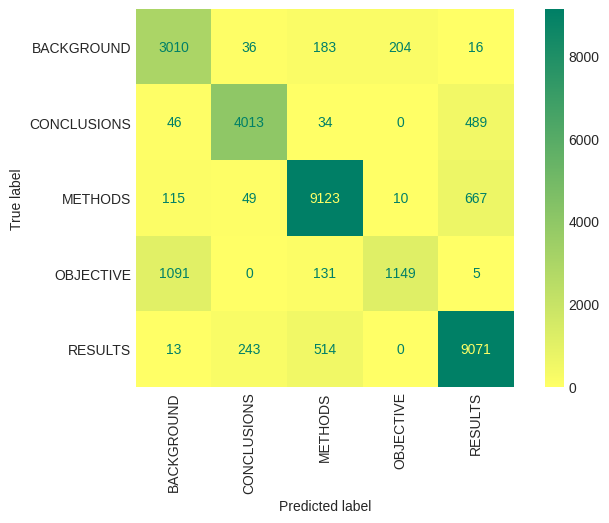

In [22]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[0]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [23]:
avaliacoes[0]

{'acuracia': 0.8726995895670594,
 'precisao': 0.8765298208622166,
 'revocacao': 0.8726995895670594,
 'pontuacao-f1': 0.8695357659432377}

# Modelo 1: Substituição do incorporador de palavras

## Modelo com incorporação de palavras particularizada

In [30]:
modelo_nome = 'modelo_incorporacao_palavras_particularizada'

entradas = Input(shape=[], dtype=ENTRADA_TIPO, name='camada_entrada_palavras')

camadas = vetorizador_palavras(entradas)
camadas = incorporador_palavras(camadas)

saidas = Bidirectional(layer=LSTM(units=int(LIMITE_INCORPORADOR / 2), activation=ATIVACAO_RNN), name='camada_bi_lstm_palavras')(camadas)

modelo_incorporacao_palavras_particularizada = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Reuso de camadas anteriores ajustadas

In [31]:
combinacao_incorporacao = Concatenate(name="camada_combinacao_incorporacao")([modelo_incorporacao_palavras_particularizada.output,
                                                                              modelo_incorporacao_caracteres.output])

abandonos_incorporacao = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_incorporacao_relu')(combinacao_incorporacao)
abandonos_incorporacao = Dropout(rate=0.5, name='camada_abandonos_incorporacao')(abandonos_incorporacao)

combinacao_linhas = Concatenate(name="camada_combinacao_linhas")([abandonos_incorporacao,
                                                                  modelo_numero_linhas.output,
                                                                  modelo_total_linhas.output])

abandonos_linhas = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_linhas_relu')(combinacao_linhas)
abandonos_linhas = Dropout(rate=0.5, name='camada_abandonos_linhas')(abandonos_linhas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(abandonos_linhas)

modelo_nome = 'modelo_1_incorporacao_palavras_particularizada'

modelo = Model(inputs=[modelo_incorporacao_palavras_particularizada.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Verificação do modelo

In [ ]:
# modelo.summary()

In [ ]:
# plot_model(modelo, show_shapes=True)

## Finalização do modelo

In [34]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                    #    validation_data=dados_hibridos_linhas_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 375s 64ms/step - loss: 0.8981 - accuracy: 0.8596 - val_loss: 0.8406 - val_accuracy: 0.8853
Epoch 2/3
5627/5627 [==============================] - 357s 63ms/step - loss: 0.8322 - accuracy: 0.9035 - val_loss: 0.8497 - val_accuracy: 0.8774
Epoch 3/3
5627/5627 [==============================] - 353s 63ms/step - loss: 0.7922 - accuracy: 0.9334 - val_loss: 0.8688 - val_accuracy: 0.8702


In [ ]:
# grafico_historico_por_iteracao(historico)

945/945 [==============================] - 21s 18ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.72      0.82      0.76      3449
 CONCLUSIONS       0.94      0.84      0.88      4582
     METHODS       0.92      0.92      0.92      9964
   OBJECTIVE       0.75      0.54      0.63      2376
     RESULTS       0.87      0.94      0.90      9841

    accuracy                           0.87     30212
   macro avg       0.84      0.81      0.82     30212
weighted avg       0.87      0.87      0.87     30212



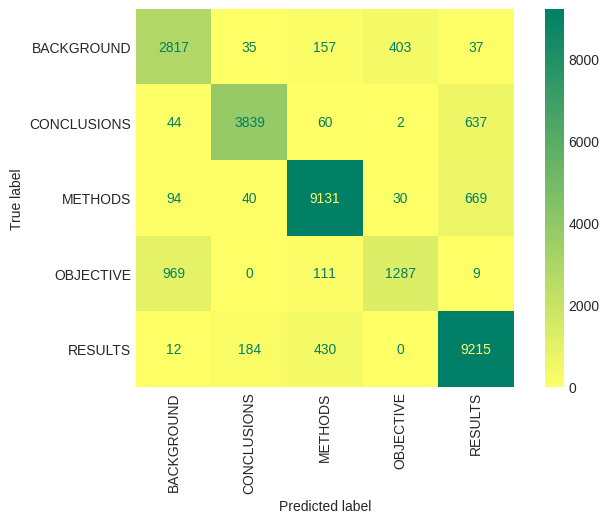

In [36]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[1]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [37]:
avaliacoes[1]

{'acuracia': 0.8701509334039454,
 'precisao': 0.871137114570525,
 'revocacao': 0.8701509334039454,
 'pontuacao-f1': 0.8681771676822914}

# Modelo 2: Otimizador de descida de gradiente estocástica

## Reuso de camadas anteriores ajustadas

In [40]:
modelo_nome = 'modelo_2_otimizador_sgd'

modelo = Model(inputs=[modelo_incorporacao_palavras_particularizada.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

## Compilação com otimizador de descida de gradiente estocástica

In [41]:
modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=SGD(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Verificação do modelo

In [ ]:
# modelo.summary()

In [ ]:
# plot_model(modelo, show_shapes=True)

## Finalização do modelo

In [44]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                       validation_data=dados_hibridos_linhas_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 328s 56ms/step - loss: 0.7701 - accuracy: 0.9464 - val_loss: 0.8549 - val_accuracy: 0.8765
Epoch 2/3
5627/5627 [==============================] - 308s 55ms/step - loss: 0.7669 - accuracy: 0.9484 - val_loss: 0.8548 - val_accuracy: 0.8771
Epoch 3/3
5627/5627 [==============================] - 309s 55ms/step - loss: 0.7661 - accuracy: 0.9488 - val_loss: 0.8546 - val_accuracy: 0.8774


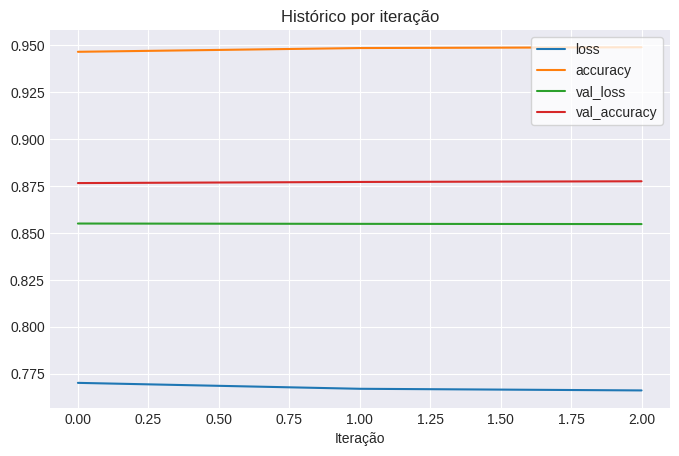

In [45]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 20s 17ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.72      0.80      0.76      3449
 CONCLUSIONS       0.91      0.90      0.90      4582
     METHODS       0.92      0.93      0.93      9964
   OBJECTIVE       0.72      0.59      0.65      2376
     RESULTS       0.91      0.91      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.84      0.83      0.83     30212
weighted avg       0.88      0.88      0.88     30212



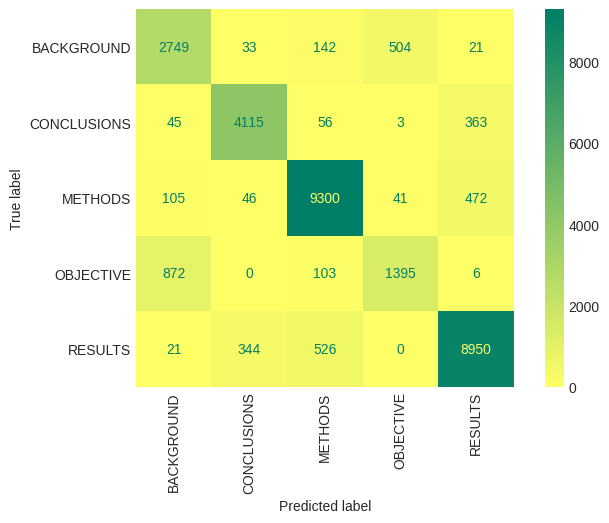

In [46]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[2]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [47]:
avaliacoes[2]

{'acuracia': 0.8774328081556997,
 'precisao': 0.8767338337897074,
 'revocacao': 0.8774328081556997,
 'pontuacao-f1': 0.8763486532994894}

# Modelo 3: Ajuste na taxa de aprendizado do otimizador

## Reuso de camadas anteriores ajustadas

In [54]:
modelo_nome = 'modelo_3_ajuste_aprendizado'

modelo = Model(inputs=[modelo_incorporacao_palavras_particularizada.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

## Ajuste na taxa de aprendizado do otimizador

In [55]:
modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=SGD(),
               metrics=METRICAS)

lrs = tf.keras.callbacks.LearningRateScheduler(lambda epoch: tf.multiply(0.001, tf.pow(10, tf.divide(epoch, 20))))

## Verificação do modelo

In [56]:
# modelo.summary()

In [57]:
# plot_model(modelo, show_shapes=True)

## Finalização do modelo

In [59]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=20,
                       validation_data=dados_hibridos_linhas_validacao,
                       callbacks=[lrs],
                       verbose=1)

Epoch 1/20
5627/5627 [==============================] - 327s 57ms/step - loss: 0.7652 - accuracy: 0.9494 - val_loss: 0.8548 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 2/20
5627/5627 [==============================] - 309s 55ms/step - loss: 0.7646 - accuracy: 0.9498 - val_loss: 0.8549 - val_accuracy: 0.8774 - lr: 0.0011
Epoch 3/20
5627/5627 [==============================] - 307s 55ms/step - loss: 0.7638 - accuracy: 0.9502 - val_loss: 0.8552 - val_accuracy: 0.8768 - lr: 0.0013
Epoch 4/20
5627/5627 [==============================] - 309s 55ms/step - loss: 0.7637 - accuracy: 0.9506 - val_loss: 0.8552 - val_accuracy: 0.8767 - lr: 0.0014
Epoch 5/20
5627/5627 [==============================] - 306s 54ms/step - loss: 0.7629 - accuracy: 0.9510 - val_loss: 0.8556 - val_accuracy: 0.8766 - lr: 0.0016
Epoch 6/20
5627/5627 [==============================] - 320s 57ms/step - loss: 0.7625 - accuracy: 0.9510 - val_loss: 0.8558 - val_accuracy: 0.8764 - lr: 0.0018
Epoch 7/20
5627/5627 [==================

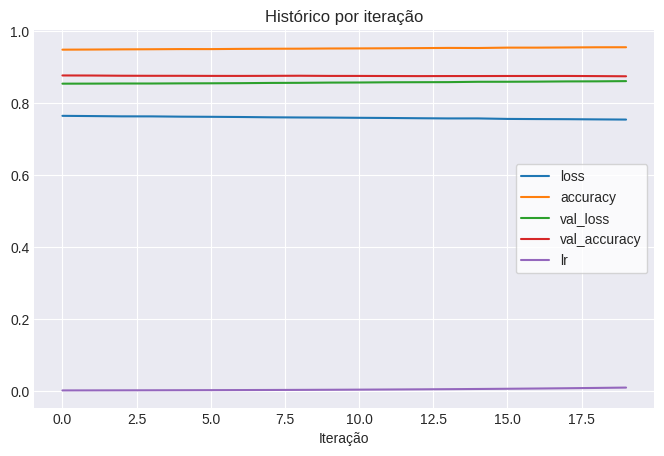

In [60]:
grafico_historico_por_iteracao(historico)

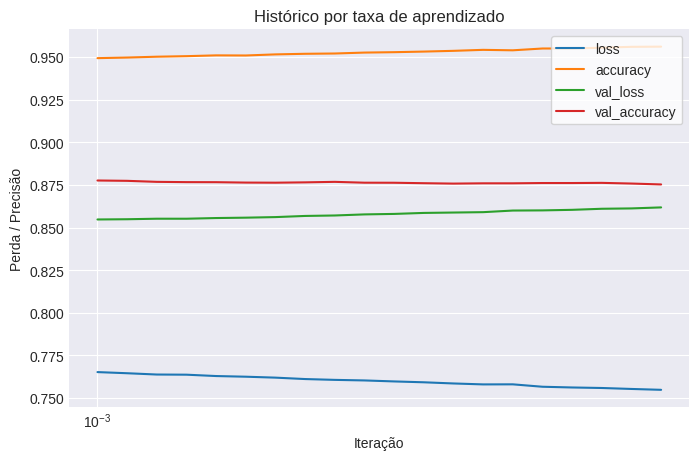

In [62]:
sns.lineplot(x=historico.history['lr'], y=historico.history['loss'], label='loss')
sns.lineplot(x=historico.history['lr'], y=historico.history['accuracy'], label='accuracy')
sns.lineplot(x=historico.history['lr'], y=historico.history['val_loss'], label='val_loss')
sns.lineplot(x=historico.history['lr'], y=historico.history['val_accuracy'], label='val_accuracy')

plt.xscale('log')

plt.title('Histórico por taxa de aprendizado')
plt.xlabel('Iteração')
plt.ylabel('Perda / Precisão')

plt.legend(frameon=True, facecolor='white');

945/945 [==============================] - 17s 18ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.72      0.78      0.75      3449
 CONCLUSIONS       0.90      0.90      0.90      4582
     METHODS       0.92      0.93      0.93      9964
   OBJECTIVE       0.69      0.60      0.64      2376
     RESULTS       0.91      0.91      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.83     30212
weighted avg       0.87      0.88      0.87     30212



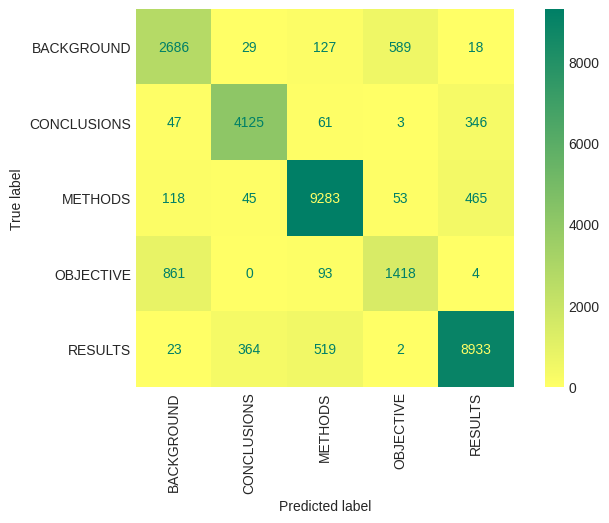

In [68]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[3]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [69]:
avaliacoes[3]

{'acuracia': 0.875314444591553,
 'precisao': 0.8747882969327773,
 'revocacao': 0.875314444591553,
 'pontuacao-f1': 0.8746526575769787}

# Comparação de modelos

In [70]:
avaliacoes = [a for a in avaliacoes if a is not None]

comparacao = pd.DataFrame(avaliacoes)
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

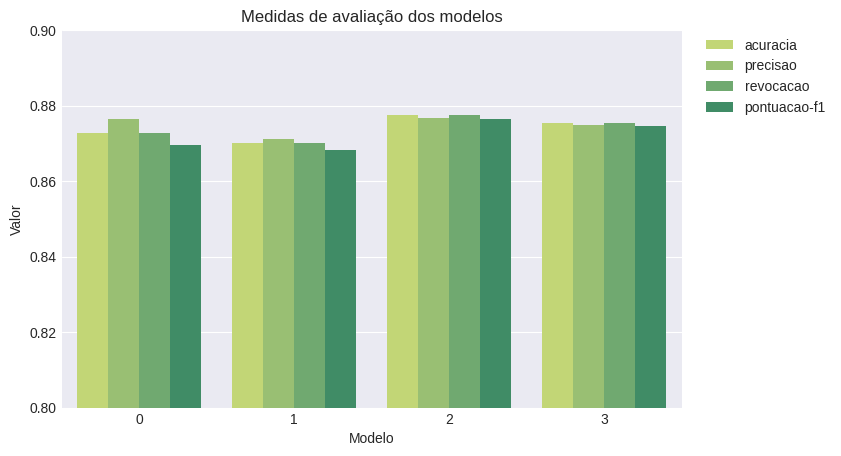

In [71]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.80, 0.90)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));

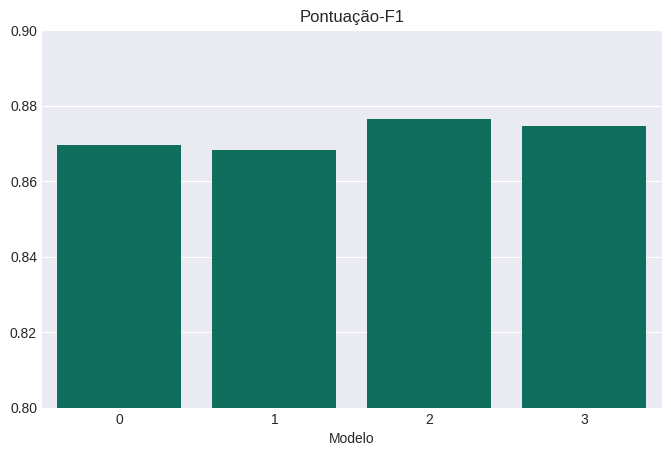

In [72]:
comparacao_f1 = pd.DataFrame([a['pontuacao-f1'] for a in avaliacoes]).T

sns.barplot(data=comparacao_f1, color=COR)

plt.ylim(0.80, 0.90)

plt.title('Pontuação-F1')
plt.xlabel('Modelo')
plt.ylabel('');